In [55]:
import matplotlib.pyplot as plt

In [56]:
import numpy as np

def simulate_sde_single(
    x0: np.ndarray,
    beta: float,
    dt: float,
    n_steps: int,
    seed: int | None = None,
    clip_to_ball: bool = True,
    ball_tol: float = 1e-6,
    chol_jitter: float = 1e-12,
    save_every: int = 10,
    include_final: bool = True,
):
    """
    Simulate one particle in R^d for:
        dX_t = -C(X_t) ∇f(X_t) dt + β Γ(X_t) dt + sqrt(2β C(X_t)) dW_t,
    with J(x)=log(1-||x||^2), C(x)=-(∇^2 J(x))^{-1} (SPD in ||x||<1),
         f(x)=||x||^2 ⇒ ∇f(x)=2x, Γ_i = Σ_j ∂_j C_{ij}(x).

    Saves the state every `save_every` iterations, plus the initial state,
    and (optionally) the final state if it wasn't already saved.

    Returns
    -------
    path : (n_saved, d) array of saved states.
    """
    assert save_every >= 1, "`save_every` must be >= 1"

    x = np.asarray(x0, dtype=float).copy()
    d = x.shape[0]
    rng = np.random.default_rng(seed)

    def metric_C(x):
        r2 = float(np.dot(x, x))
        a = 0.5 * (1.0 - r2)
        b = (1.0 - r2) / (1.0 + r2)
        return a * np.eye(d) - b * np.outer(x, x)  # C = a I - b x x^T

    def gamma_divC(x):
        r2 = float(np.dot(x, x))
        coeff = (-(d + 2) + 2.0 * r2 + d * (r2 ** 2)) / ((1.0 + r2) ** 2)
        return coeff * x

    def grad_f(x):
        return x

    def project_inside_unit_ball(x):
        r = np.linalg.norm(x)
        if r >= (1.0 - ball_tol):
            x = x * ((1.0 - ball_tol) / max(r, 1e-16))
        return x

    if clip_to_ball:
        x = project_inside_unit_ball(x)

    saved = [x.copy()]  # always include initial state

    sqrt_2beta = np.sqrt(2.0 * beta)
    sqrtdt = np.sqrt(dt)

    for step in range(1, n_steps + 1):
        C = metric_C(x)
        drift = -C @ grad_f(x) + beta * gamma_divC(x)

        # Cholesky for sqrt(C)
        C_pd = C + chol_jitter * np.eye(d)
        L = np.linalg.cholesky(C_pd)

        # noise term: sqrt(2β) * L * (sqrt(dt) * ξ), ξ ~ N(0, I)
        xi = rng.standard_normal(d)
        noise = sqrt_2beta * (L @ (sqrtdt * xi))

        # Euler–Maruyama update
        x = x + drift * dt + noise
        if clip_to_ball:
            x = project_inside_unit_ball(x)

        # save on schedule
        if step % save_every == 0:
            saved.append(x.copy())

    # ensure final state is saved if not already
    if include_final and (n_steps % save_every != 0):
        saved.append(x.copy())

    return np.stack(saved, axis=0)

(8001, 3)


In [76]:
d = 20
beta = 1.0
dt_vals = [0.05, 0.01, 0.005, 0.001]
results = []
for dt in dt_vals:
    steps = int(5_000 / dt)
    x0 = np.zeros(d)
    traj = simulate_sde_single(x0, beta, dt, steps, seed=None, save_every=int(0.1 / dt))
    results.append(traj)

In [90]:
for traj, dt in zip(results, dt_vals):
    # np.savetxt(f'traj_dt_{dt}.csv', traj)
    print(dt, abs(np.linalg.norm(traj, axis=-1).mean() - expected))

0.05 0.04776836599226175
0.01 0.01282915319220923
0.005 0.006989350893211288
0.001 0.0011834467824308748


In [77]:
expected = 0.950428661907089

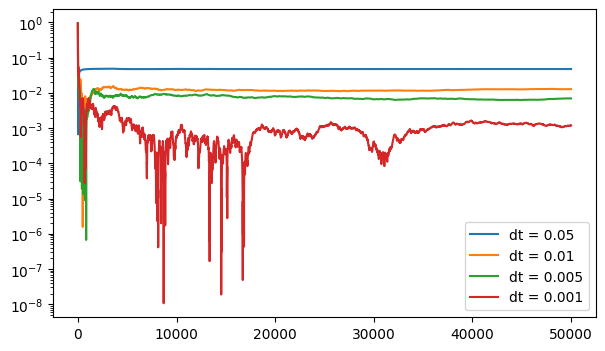

In [89]:
plt.figure(figsize=(7, 4))
# plt.title(r"$\bigg{|}\mathbb{E}[\|x\|] - \frac{1}{N}\sum_{n=1}^N X_n\bigg{|}$")
for traj, dt in zip(results, dt_vals):
    cum_mean = np.linalg.norm(traj, axis=-1).cumsum() / np.arange(1, len(traj) + 1)
    plt.plot(abs(cum_mean - expected), label=f'dt = {dt}')
# plt.plot([1, len(traj) + 1], [expected, expected])
plt.yscale('log')
plt.legend();

In [58]:
int(0.1 / dt)

100.0

In [59]:
1e-2

0.01

In [57]:
steps * dt

200.0

In [54]:
samples = np.random.normal(0, 1, size=(10_000, 3))
samples = samples[np.linalg.norm(samples, axis=-1) <= 0.5]
np.linalg.norm(samples, axis=-1).mean(), len(samples)

(np.float64(0.3734120926561028), 285)

In [44]:
# plt.plot(np.linalg.norm(samples, axis=-1))

In [4]:
np.linalg.norm(traj, axis=-1).mean()

np.float64(0.7233469897029939)

In [102]:
traj.shape

(8001, 3)

(array([[ 148.,  610., 1172., 1174., 1194., 1130., 1037.,  815.,  523.,
          198.],
        [ 140.,  537.,  922., 1167., 1298., 1449., 1073.,  836.,  405.,
          174.],
        [ 376.,  498.,  798., 1087., 1163., 1193., 1103.,  813.,  539.,
          431.]]),
 array([-0.99661291, -0.79908592, -0.60155892, -0.40403192, -0.20650492,
        -0.00897793,  0.18854907,  0.38607607,  0.58360307,  0.78113006,
         0.97865706]),
 <a list of 3 BarContainer objects>)

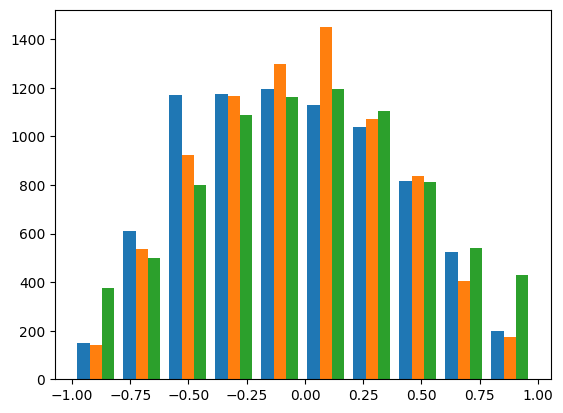

In [103]:
plt.hist(traj)

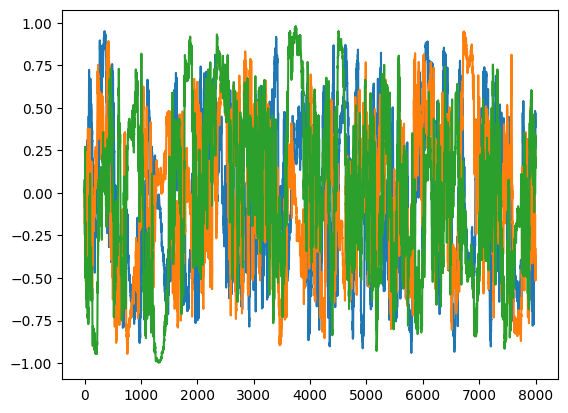

In [104]:
plt.plot(traj)

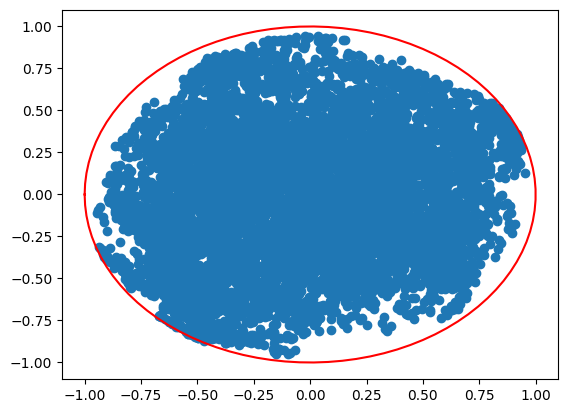

In [77]:
plt.scatter(traj[:, 0], traj[:, 1])

theta_vals = np.linspace(-np.pi, np.pi, 100)
plt.plot(np.cos(theta_vals), np.sin(theta_vals), color='red')